In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
import nltk
from nltk.tokenize import word_tokenize
from itertools import chain

In [4]:
nltk.download('punkt') #for tokenization

[nltk_data] Downloading package punkt to /home/haarrublar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
## loading the data without validation set (maybe in a second example)

# training and testing data
with open('X_train.txt') as train, open('X_test.txt') as test:
    X_train = train.read()
    X_test = test.read()

# training output
y_train = np.load('y_train.npy')

In [7]:
import re
import nltk


nltk.download('stopwords')

class DataCleaner:
    def __init__(self, stopwords=True):
        try:
            self.stop = nltk.corpus.stopwords.words('english')
            self.pattern = self.construct_pattern(stopwords)
        except Exception as e:
            print(f"Error initializing stopwords: {e}")
            self.stop = []
            self.pattern = ""

    def construct_pattern(self, stopwords=True):
        try:
            stopwords_pattern = r'\b(?:' + '\s*|'.join(map(re.escape, self.stop)) + r')\b' if stopwords else ''
            return stopwords_pattern + r'|[^\w\s]'
        except Exception as e:
            print(f"Error constructing pattern: {e}")
            return ""

    def clean_text(self, text):
        try:
            clean_data = [None]
            for _ in range(1):
                clean_data[0] = text.lower().split('\n')
                clean_data[0] = list(map(lambda x: re.sub(self.pattern, '', x), clean_data[0]))
            return clean_data[0]
        except AttributeError:
            print("Error: Input text is not a string.")
            return []
        except Exception as e:
            print(f"Error cleaning text: {e}")
            return []


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/haarrublar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
cleaner = DataCleaner()
text = cleaner.clean_text(X_train)

train_x = tf.constant(text)
train_y = tf.constant(y_train.flatten()) # the values must be flattened before entering to the model

2024-04-23 11:41:42.109225: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
train_x = tf.data.Dataset.from_tensor_slices(text)

In [20]:
for e in train_x.take(2):
    print(e)

tf.Tensor(b'came witches stayed gwent', shape=(), dtype=string)
tf.Tensor(b'great horror game get little repetitive new fresh set maps ideallevel system trash never confused 2 addons offerings perk systemmajor downfall matchmaking system thrown level 39 killer 3 4 survivors level 1', shape=(), dtype=string)


2024-04-23 11:47:03.373594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1000]
	 [[{{node Placeholder/_0}}]]


In [91]:
def _CreateTable(vocab, num_oov=1):
    init = tf.lookup.KeyValueTensorInitializer(
        vocab, tf.range(tf.size(vocab, out_type=tf.int64),
                        dtype=tf.int64),key_dtype=tf.string,
                        value_dtype=tf.int64)
    
    return tf.lookup.StaticVocabularyTable(init, num_oov, lookup_key_dtype=tf.string)

In [89]:
tf_vocab = []

with open('vocab.txt', 'r') as fp:
    for line in fp:
        x = line[:-1]
        tf_vocab.append(x)

In [116]:
# simple tokenization using nltk library
text_premodel_tokenization = list(map(word_tokenize, text))

# flatten the list using itertools
def flatten_chain(element):
    return list(chain.from_iterable(element))

text_premodel_tokenization = list(set(flatten_chain(text_premodel_tokenization))) ## avoiding repetition IMPORTANT

In [115]:
tf_vocab_table = _CreateTable(tf_vocab)
text_vocab = _CreateTable(text_premodel_tokenization)

In [170]:
def preprocess(data, labels):
    tokenizer = tf_text.WhitespaceTokenizer()
    data = tokenizer.tokenize(data)
    ids = tf.ragged.map_flat_values(tf_vocab_table.lookup, data) # the vocab might be text_vocab vs tf_vocab_table
    return (ids, labels)

In [174]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(2)
train_dataset = train_dataset.map(preprocess)

In [187]:
# to check the dimension of the data
# for data, labels in train_dataset:
#     print("Data shape:", data.shape)
#     print("Labels shape:", labels.shape)

In [182]:
def preprocess(data, labels):
    subtokenizer = tf_text.WhitespaceTokenizer()
    tokenizer = tf_text.BertTokenizer(tf_vocab_table, token_out_type=tf.string)

    subtoken = subtokenizer.tokenize(data)
    data = tokenizer.tokenize(subtoken)

    data = data.merge_dims(-2,-1).merge_dims(-2,-1) # the dimension is (2,None,None,None) and it needs to be reduced for entering to the model
    ids = tf.ragged.map_flat_values(tf_vocab_table.lookup, data) # the vocab might be text_vocab vs tf_vocab_table
    return (ids, labels)

In [183]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(2)
train_dataset = train_dataset.map(preprocess)

In [186]:
# to check the dimension of the data
# for data, labels in train_dataset:
#     print("Data shape:", data.shape)
#     print("Labels shape:", labels.shape)


In [201]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(None,), dtype='int64', ragged=True),
  tf_text.keras.layers.ToDense(pad_value=0, mask=True),
  tf.keras.layers.Embedding(10000, 16),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
  optimizer="rmsprop",
  loss="binary_crossentropy",
  metrics=["accuracy"])

output = model.fit(train_dataset, epochs=20, batch_size=10, verbose=1)

2024-04-20 21:37:19.595234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-20 21:37:19.596588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-20 21:37:19.597487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.data.ops.map_op._MapDataset'>]

In [199]:
# output.history.keys()
print(output.history['loss'])

[0.6562934517860413, 0.6723963022232056, 0.6119150519371033, 0.642501175403595, 0.5707395672798157, 0.5841512084007263, 0.4926207363605499, 0.4474377930164337, 0.37961727380752563, 0.26072055101394653, 0.22295743227005005, 0.18755149841308594, 0.1651945263147354, 0.18122071027755737, 0.1640462726354599, 0.13373808562755585, 0.14942046999931335, 0.12762980163097382, 0.12019527703523636, 0.11414709687232971]


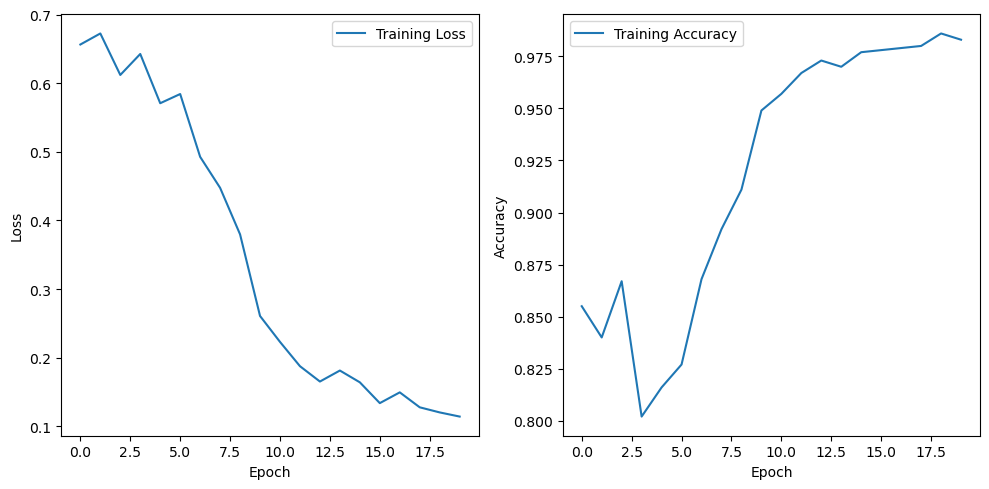

In [200]:
import matplotlib.pyplot as plt

# Extract the loss and accuracy values from the output
loss = output.history['loss']
accuracy = output.history['accuracy']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
